In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.utils import img_to_array
import gc

In [2]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
color_img = []
path = './landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == '7200.jpg':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img_to_array(img))
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[0:2000])).batch(20)
#del color_img
gc.collect()

gray_img = []
path = './landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
         if i == '7200.jpg':
            break
         else: 
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[0:2000])).batch(20)
#del gray_img
#del files
#del path
#del i
#del img
gc.collect()

100%|██████████| 7129/7129 [00:09<00:00, 790.17it/s] 


9

In [3]:
example_color = next(iter(color_dataset))
example_gray = next(iter(gray_dataset))

In [4]:
def plot_images(a = 4):
    
    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('gray')
        plt.imshow(example_gray[i])
        plt.show()

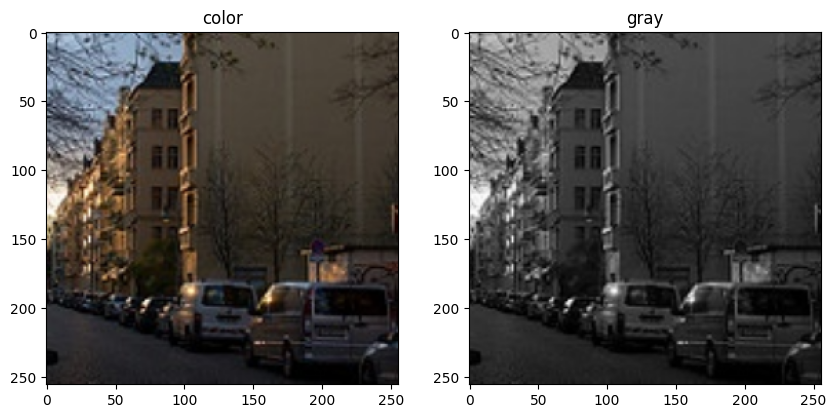

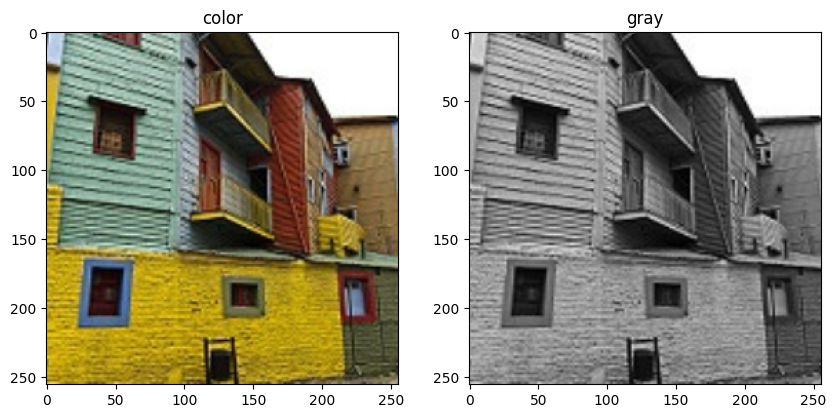

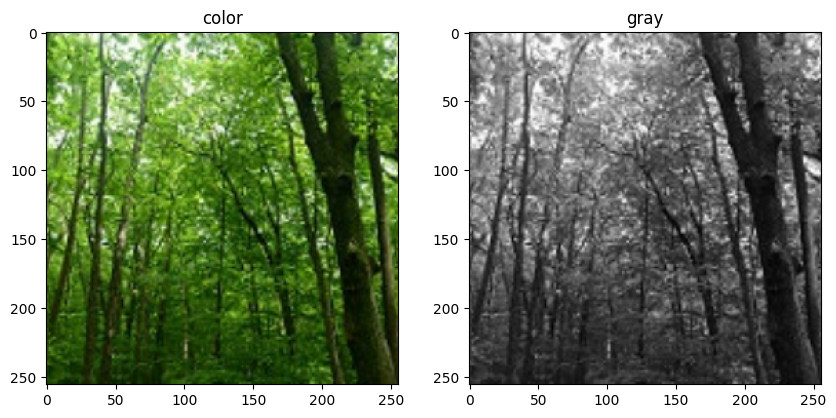

In [5]:
plot_images(3)

c:\Users\Jeff\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [7]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [8]:
def generate_images(model, test_input, tar,n):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.savefig('E:/TER/landscape Images/output/plt'+str(n)+'.jpg')
  plt.show()

In [9]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
  print('epoch :',epoch,'gen_total_loss :',gen_total_loss.numpy(),'disc_loss :',disc_loss.numpy())
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [10]:
import time
def fit(epochs):
  for epoch in range(epochs):
    start = time.time()
    print("Epoch: ", epoch+1)
    # Train
    color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[0:1749])).batch(16)
    gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[0:1749])).batch(16)
    for n, (input_image, target) in tf.data.Dataset.zip((gray_dataset, color_dataset)).enumerate():
      train_step(input_image, target, epoch)      
    del color_dataset
    del gray_dataset
    gc.collect()
    color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[1750:3499])).batch(16)
    gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[1750:3499])).batch(16)
    for n, (input_image, target) in tf.data.Dataset.zip((gray_dataset, color_dataset)).enumerate():
      train_step(input_image, target, epoch)
    del color_dataset
    del gray_dataset
    gc.collect()
    color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[3500:5249])).batch(16)
    gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[3500:5249])).batch(16)
    for n, (input_image, target) in tf.data.Dataset.zip((gray_dataset, color_dataset)).enumerate():
      train_step(input_image, target, epoch)
    del color_dataset
    del gray_dataset
    gc.collect()
    color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[5250:6999])).batch(16)
    gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[5250:6999])).batch(16)
    for n, (input_image, target) in tf.data.Dataset.zip((gray_dataset, color_dataset)).enumerate():
      train_step(input_image, target, epoch)
    del color_dataset
    del gray_dataset
    gc.collect()
    color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[7000:])).batch(16)
    gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[7000:])).batch(16)
    for n, (input_image, target) in tf.data.Dataset.zip((gray_dataset, color_dataset)).enumerate():
      train_step(input_image, target, epoch)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    generator.compile()
    discriminator.compile()
    generator.save('E:/TER/model/generator.h5')
    discriminator.save('E:/TER/model/discriminator.h5')
    del color_dataset
    del gray_dataset
    gc.collect()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


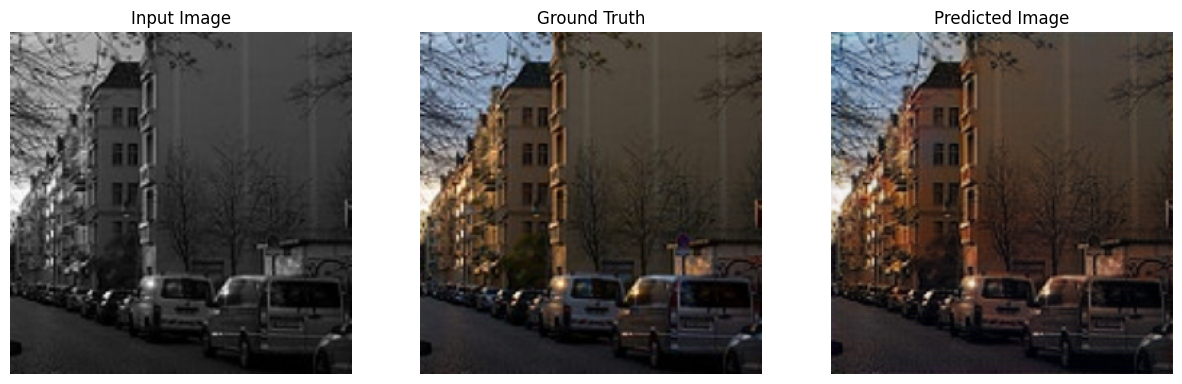

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


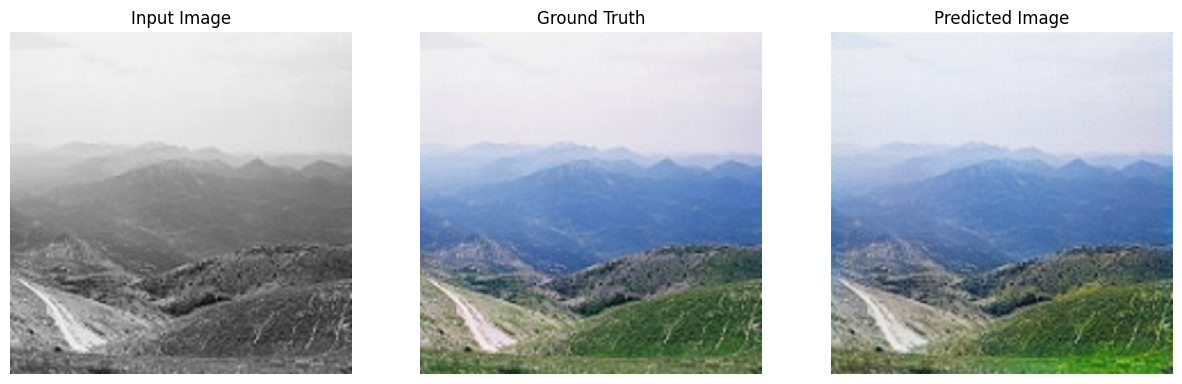

In [11]:
for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target,0)

In [12]:
fit(1)

Epoch:  1
epoch : 0 gen_total_loss : 12.050995 disc_loss : 0.00017333237
epoch : 0 gen_total_loss : 12.218751 disc_loss : 0.00042733573
epoch : 0 gen_total_loss : 11.658441 disc_loss : 0.00038708036
epoch : 0 gen_total_loss : 10.382614 disc_loss : 0.0008568029
epoch : 0 gen_total_loss : 12.1834345 disc_loss : 0.0008446085
epoch : 0 gen_total_loss : 12.6996975 disc_loss : 0.00019435034
epoch : 0 gen_total_loss : 12.1950245 disc_loss : 0.00015461215
epoch : 0 gen_total_loss : 14.386455 disc_loss : 0.0001607479
epoch : 0 gen_total_loss : 10.521509 disc_loss : 0.0008473241
epoch : 0 gen_total_loss : 5.9472184 disc_loss : 0.040106904
epoch : 0 gen_total_loss : 16.872166 disc_loss : 0.0002399111
epoch : 0 gen_total_loss : 18.288897 disc_loss : 0.28684124
epoch : 0 gen_total_loss : 19.248856 disc_loss : 0.0010457127
epoch : 0 gen_total_loss : 16.335365 disc_loss : 0.00013495206
epoch : 0 gen_total_loss : 15.666067 disc_loss : 0.00022459136
epoch : 0 gen_total_loss : 16.77108 disc_loss : 0.000

In [13]:
color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[6000:])).batch(1)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[6000:])).batch(1)
n = 0
for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)):
  generate_images(generator, example_input, example_target,n)
  n=n+1